In [1]:
import sys, pickle
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

sys.path.append("../src/")
from config import *
from dataio import (load_dam_details, load_dam_discharge, load_dam_network, 
                    load_basin_msm, load_basin_te, load_basin_shapes)

### Plot helpers

In [5]:
import bokeh, shapely
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure
from bokeh.tile_providers import CARTODBPOSITRON, get_provider
from bokeh.io import output_file, output_notebook, show
import pyproj
from pyproj import Transformer

output_notebook()

def translate_coords(coords, src=3857, dst=4326):
    trans = Transformer.from_crs(f'epsg:{dst}', f'epsg:{src}')
    return [trans.transform(*c) for c in coords]

def get_coord(shape):
    if isinstance(shape, shapely.geometry.multilinestring.MultiLineString):
        xs,ys = [],[]
        for line in shape:
            x,y = get_coord(line)
            xs+=x
            ys+=y
    elif isinstance(shape, shapely.geometry.linestring.LineString):
        X,Y = shape.xy[0].tolist(), shape.xy[1].tolist()
        xs = list(zip(X[1:], X[:-1]))
        ys = list(zip(Y[1:], Y[:-1]))
    else:
        print(type(shape))
        raise Exception
    return xs,ys

def get_catchment_shapes(idx):
    gdf = load_basin_shapes(idx).to_crs(epsg=3857)
    xs,ys = [],[]
    for idx in gdf.index:
        geom = gdf.loc[idx]["geometry"]
        x,y = get_coord(geom.boundary)
        xs += x
        ys += y
    return xs, ys


Loading BokehJS ...

### Visualize dam catchment distribution

There are 115 for which we have basin info, 127 for which we have discharge info


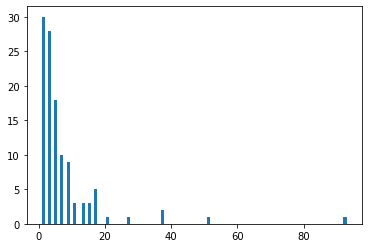

In [4]:
details = load_dam_details()
with open(dam_networks_path, "rb") as f:
    networks = pickle.load(f)
print(f"There are {len(networks)} for which we have basin info, {len(details)} for which we have discharge info")
plt.hist([len(x) for x in networks.values()], bins=100);

### Plot interactive map of a few dam watershed

In [10]:
i = 0
BS = 30

dams = list(networks.keys())
dam_idxs = dams[i*BS:(i+1)*BS]

xs,ys = [],[]
for dam_idx in dam_idxs:
    x,y = get_catchment_shapes(dam_idx)
    xs+=x
    ys+=y
    
source = ColumnDataSource(pd.DataFrame({"x":xs, "y":ys}))

X,Y = zip(*translate_coords([(x,y) for x,y in details["coordinates"].loc[dam_idxs].values]))
source_dam = ColumnDataSource(pd.DataFrame({"x":X,"y":Y}))

p1 = figure()
p1.add_tile(get_provider(CARTODBPOSITRON))
p1.multi_line('x', 'y', source=source, color="black", line_width=2)
p1.circle(x="x", y="y", color='red', source=source_dam, size=2);
show(p1)